In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 方案（三种类型的网络整合）
## ① 所有蛋白pair之间的权重网络（cosine similarity-top5%）

In [2]:
n_model = 1

In [3]:
pairwise_cosim = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/pairwise_cosine/model_{n_model}.pkl')

In [ ]:
pairwise_cosim_ndarray = pairwise_cosim.to_numpy()
pairwise_cosim_idx = np.tril_indices_from(pairwise_cosim_ndarray, -1)
idx0, idx1 = pairwise_cosim_idx[0].tolist(), pairwise_cosim_idx[1].tolist()

In [ ]:
pairwise_cosim_ltri = pairwise_cosim_ndarray[idx0, idx1]

In [ ]:
pairwise_cosim_ltri

In [ ]:
pairwise_cosim_ltri_df = pd.DataFrame({
    'idx0': idx0,
    'idx1': idx1,
    'cosine': pairwise_cosim_ltri
})
temp_dict = dict(zip(np.arange(len(pairwise_cosim.columns)), pairwise_cosim.columns))
pairwise_cosim_ltri_df['A'] = pairwise_cosim_ltri_df['idx0'].map(temp_dict)
pairwise_cosim_ltri_df['B'] = pairwise_cosim_ltri_df['idx1'].map(temp_dict)

In [ ]:
pairwise_cosim_ltri_df.loc[pairwise_cosim_ltri_df['cosine'] > 1, 'cosine_fixed'] = 1
pairwise_cosim_ltri_df.loc[pairwise_cosim_ltri_df['cosine'] < 0, 'cosine_fixed'] = 0
pairwise_cosim_ltri_df['cosine_fixed'] = pairwise_cosim_ltri_df['cosine_fixed'].fillna(pairwise_cosim_ltri_df['cosine'])

In [ ]:
top1_cosine_thre = pairwise_cosim_ltri_df['cosine_fixed'].quantile(.99)

In [ ]:
cutoff = top1_cosine_thre
pairwise_cosim_top1_df = pairwise_cosim_ltri_df[pairwise_cosim_ltri_df['cosine_fixed']>=cutoff].reset_index(drop=True)

In [ ]:
pairwise_cosim_top1_df

In [4]:
edges = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_{n_model}.pkl')

In [ ]:
cutoff = edges['cosim'].quantile(.95)
pairwise_cosim_high_df = pairwise_cosim_ltri_df[pairwise_cosim_ltri_df['cosine_fixed']>=cutoff].reset_index(drop=True)

In [ ]:
pairwise_cosim_high_df

In [ ]:
pairwise_cosim_high_df['cosine_fixed'].std()

### Cosine Similarity Top1% and High组成网络的连通性

In [5]:
import networkx as nx
def dataframe2graph(interactome_df, mcc=True):
    G = nx.Graph()
    G.add_edges_from(interactome_df.to_numpy())
    if mcc:
        c = max(nx.connected_components(G), key=len)
        G_mcc = G.subgraph(c)
        return G_mcc
    else:
        return G

In [ ]:
g1 = dataframe2graph(pairwise_cosim_top1_df[['A', 'B']].copy(), mcc=False)
g2 = dataframe2graph(pairwise_cosim_top1_df[['A', 'B']].copy(), mcc=True)
fr1 = len(g2.nodes) / len(g1.nodes)

g1 = dataframe2graph(pairwise_cosim_high_df[['A', 'B']].copy(), mcc=False)
g2 = dataframe2graph(pairwise_cosim_high_df[['A', 'B']].copy(), mcc=True)
fr2 = len(g2.nodes) / len(g1.nodes)

print('约有{:.3f}左右的点在Cosine Similarity Top1%组成的连通网络中，约有{:.3f}左右的点在Cosine Similarity High组成的连通网络中'.format(fr1, fr2))

约有0.965左右的点在Cosine Similarity Top1%组成的连通网络中，约有0.821左右的点在Cosine Similarity High组成的连通网络中


### Cosine Similarity High

In [43]:
pairwise_cosim_high_df[0] = np.sort(pairwise_cosim_high_df[['A', 'B']].values).sum(axis=1)

In [44]:
pairwise_cosim_high_g = dataframe2graph(pairwise_cosim_high_df[['A', 'B']].copy(), mcc=True)

In [51]:
pairwise_cosim_high_e = pd.DataFrame(pairwise_cosim_high_g.edges)
pairwise_cosim_high_e.columns = ['A', 'B']
pairwise_cosim_high_e[0] = np.sort(pairwise_cosim_high_e[['A', 'B']].values).sum(axis=1)

In [54]:
temp_dict = pairwise_cosim_high_df.set_index(0).to_dict()['cosine_fixed']
pairwise_cosim_high_e['weight'] = pairwise_cosim_high_e[0].map(temp_dict)

In [55]:
pairwise_cosim_high_e

,A,B,0,weight
0,A0PJY2,A0PJW8,A0PJW8A0PJY2,0.893243
1,A0PJY2,A2VCK2,A0PJY2A2VCK2,0.883817
2,A0PJY2,A8K0Z3,A0PJY2A8K0Z3,0.916607
3,A0PJY2,O00560,A0PJY2O00560,0.904533
4,A0PJY2,O14490,A0PJY2O14490,0.913732
...,...,...,...,...
183318,Q9Y6H6,Q9UDY4,Q9UDY4Q9Y6H6,0.869734
183319,Q9Y6I9,Q8WVV5,Q8WVV5Q9Y6I9,0.922373
183320,Q9Y6R4,Q5TGL8,Q5TGL8Q9Y6R4,0.868552
183321,Q9Y6R4,Q9NYR9,Q9NYR9Q9Y6R4,0.894991


## ② 无权重/有权重的整合PPIN

In [59]:
edges_w = edges[['A', 'B', 'cosim']].copy()
edges_w = edges_w.rename(columns={'cosim': 'weight'})
edges_unw = edges[['A', 'B']].copy()
edges_unw['weight'] = 1

In [187]:
edges_g = dataframe2graph(edges[['A', 'B']], mcc=True)
print('Integrated PPIN with {} nodes and {} edges'.format(len(edges_g.nodes), len(edges_g.edges)))

Integrated PPIN with 15939 nodes and 241464 edges


## ③ Single-cell expression network (B-cell specific)

In [6]:
entrymap_df = pd.read_pickle('/home/lyz/co-phase-separation/question1/reults_data/HUMAN_9606_idmapping.pkl')
symbol2entry_dict = entrymap_df[entrymap_df['ID_types']=='GeneSymbol'].set_index('IDs').to_dict()['uniprot_entry']

scnet_df = pd.read_table('./data/PPIN/Immune-Specific_Network_B.txt')

scnet_df['A'] = scnet_df['geneA'].map(symbol2entry_dict)
scnet_df['B'] = scnet_df['geneB'].map(symbol2entry_dict)
scnet_df = scnet_df[(scnet_df['A'].notna())&(scnet_df['B'].notna())][['A', 'B', 'weight']]

scnet_df['weight'] = scnet_df['weight'] / 1e3
scnet_df['weight'] = scnet_df['weight'].apply(lambda x: round(x, 4))

In [7]:
from itertools import chain

def chainer(s, sep):
    return list(chain.from_iterable(s.str.split(sep)))

def split_items(dataframe, col_name, sep):
    lens = dataframe[col_name].str.split(sep).map(len)
    cols = dataframe.columns
    dict1 = {c: np.repeat(dataframe[c], lens) for c in cols}
    dict1[col_name] = chainer(dataframe[col_name], sep)
    return pd.DataFrame(dict1)

In [8]:
scnet_df = split_items(split_items(scnet_df, 'A', ','), 'B', ',').reset_index(drop=True)

### 单细胞表达量网络的连通性

In [69]:
g1 = dataframe2graph(scnet_thre_df[['A', 'B']].copy(), mcc=False)
g2 = dataframe2graph(scnet_thre_df[['A', 'B']].copy(), mcc=True)
fr3 = len(g2.nodes) / len(g1.nodes)

print('约有{:.3f}左右的点在single-cell expression network组成的连通网络中'.format(fr3))

约有1.000左右的点在single-cell expression network组成的连通网络中


In [84]:
scnet_thre_df['weight'].std()

0.06411680644855128

## 网络的存储

In [13]:
import os
SAVE_ROOT_BIONIC = '/home/lyz/co-phase-separation/software/BIONIC-0.1.0/bionic/inputs/'

In [89]:
# single-cell expr network
cutoffs = np.arange(.1, .6, .1)
for c in cutoffs:
    temp_df = scnet_df[scnet_df['weight'] >= c].reset_index(drop=True)
    # temp_g = dataframe2graph(temp_df[['A', 'B']].copy(), mcc=True)
    nodes = set(pd.concat([temp_df['A'], temp_df['B']]))
    temp_df[0] = np.sort(temp_df[['A', 'B']].values).sum(axis=1)
    edges = set(temp_df[0])
    print('Network {} nodes and {} edges with edge cutoff {:.2f}'.format(len(nodes), len(edges), c))
    # temp_df[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'single-cell_exprnet_B_gt0{}.txt'.format(int(c * 10))), index=None, header=None, sep=' ')

Network 2886 nodes and 203242 edges with edge cutoff 0.10
Network 1230 nodes and 46810 edges with edge cutoff 0.20
Network 492 nodes and 9889 edges with edge cutoff 0.30
Network 188 nodes and 1703 edges with edge cutoff 0.40
Network 68 nodes and 412 edges with edge cutoff 0.50


In [ ]:
"""
prot_in_edge_unw = set(pd.concat([edges_unw['A'], edges_unw['B']]).drop_duplicates())
prot_in_scnet_thre = set(pd.concat([scnet_thre_df['A'], scnet_thre_df['B']]).drop_duplicates())
prot_in_pairwise_cosim = set(pd.concat([pairwise_cosim_high_e['A'], pairwise_cosim_high_e['B']]).drop_duplicates())
"""

In [ ]:
pairwise_cosim_high_e[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'cosine_similarity_high.txt'), index=None, header=None, sep=' ')
edges_unw[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'unweighted_integ_PPIN.txt'), index=None, header=None, sep=' ')
edges_w[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'weighted_integ_PPIN.txt'), index=None, header=None, sep=' ')
# scnet_thre_df[['A', 'B', 'weight']].to_csv(os.path.join(SAVE_ROOT_BIONIC, 'single-cell_exprnet_B_gt01.txt'), index=None, header=None, sep=' ')

# Processing BIONIC outputs

In [94]:
embeds = pd.read_table('/home/lyz/co-phase-separation/software/BIONIC-0.1.0/bionic/outputs/unweighted_sc_gt02_features.tsv').set_index('Unnamed: 0')

In [95]:
import networkx as nx
def adjmat2graph(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    g = nx.Graph()
    g.add_edges_from(edges)
    return g

def process_BIONIC_outputs(embeds, cutoff=.5):
    array1 = embeds.to_numpy()
    array2 = array1.T
    array_dot = np.dot(array1, array2)
    
    adjmat = np.array(array_dot >= cutoff, dtype=np.int)
    g = adjmat2graph(adjmat)
    edge_df = pd.DataFrame(g.edges)
    
    index2entry_dict = dict(zip(np.arange(len(embeds.index)), embeds.index))
    edge_df['A'] = edge_df[0].map(index2entry_dict)
    edge_df['B'] = edge_df[1].map(index2entry_dict)
    
    weights_df = pd.DataFrame(array_dot)
    weights_df.columns = embeds.index.tolist()
    weights_df.index = embeds.index.tolist()
    
    from tqdm import tqdm
    edge_weights = list()
    for _, i in tqdm(edge_df.iterrows()):
        a, b = i['A'], i['B']
        w = weights_df[a][b]
        # print(a, b, w)
        edge_weights.append(w)
    edge_df['w'] = edge_weights
    edge_df = edge_df[edge_df['A']!=edge_df['B']].reset_index(drop=True)
    return edge_df

In [96]:
bionic_net = process_BIONIC_outputs(embeds, cutoff=.5)

5112it [00:00, 18462.60it/s]


In [97]:
bionic_net

,0,1,A,B,w
0,13,8968,A0AVF1,Q86WT1,0.559566
1,13,9657,A0AVF1,Q8N4P2,0.579386
2,13,11205,A0AVF1,Q96AJ1,0.504355
3,13,13928,A0AVF1,Q9NQC8,0.560473
4,13,14659,A0AVF1,Q9P2H3,0.589003
...,...,...,...,...,...
4758,14540,14729,Q9P000,Q9UBI1,0.506989
4759,8068,8927,Q6R2W3,Q86W11,0.517091
4760,8927,12460,Q86W11,Q9BRR0,0.521167
4761,8927,14563,Q86W11,Q9P0L1,0.534753


## Venn diagram

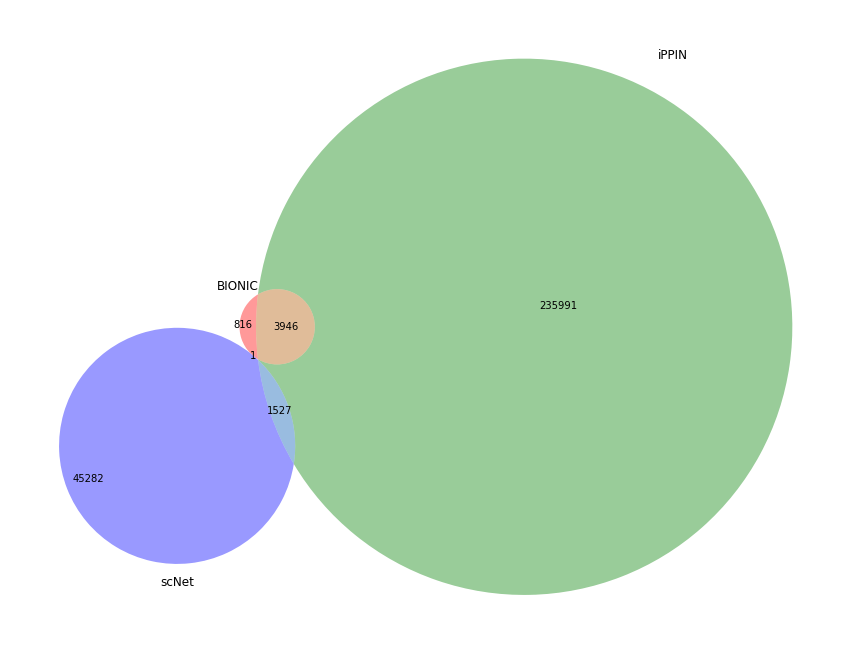

In [98]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
fig, ax = plt.subplots(figsize=(15, 15))

# BIONIC NETWORK
set1 = set(np.sort(bionic_net[['A', 'B']].values).sum(axis=1))
# INTEGRATED PPIN
edges = pd.read_pickle(f'./saves/INTEGRATE_unweight_ProSE80d_mcc/edge_cosine/model_{n_model}.pkl')
set2 = set(edges[0])
# scNet
temp_df = scnet_df[scnet_df['weight'] >= .2].reset_index(drop=True)
temp_df[0] = np.sort(temp_df[['A', 'B']].values).sum(axis=1)
set3 = set(temp_df[0])

venn3([set1, set2, set3], ('BIONIC', 'iPPIN', 'scNet'), ax=ax)

In [61]:
bionic_g = dataframe2graph(bionic_net[['A', 'B']].copy(), mcc=True)

In [62]:
nx.density(bionic_g)

0.6206896551724138

In [34]:
bionic_net['c'] = np.sort(bionic_net[['A', 'B']].values).sum(axis=1)
c2w_dict = bionic_net.set_index('c').to_dict()['w']
bionic_g_e = pd.DataFrame(bionic_g.edges)
bionic_g_e.columns = ['A', 'B']
bionic_g_e[0] = np.sort(bionic_g_e[['A', 'B']].values).sum(axis=1)
bionic_g_e['w'] = bionic_g_e[0].map(c2w_dict)

In [38]:
bionic_g_e.loc[bionic_g_e['w'] > 1, 'w.fixed'] = 1
bionic_g_e.loc[bionic_g_e['w'] < 0, 'w.fixed'] = 0
bionic_g_e['w.fixed'] = bionic_g_e['w.fixed'].fillna(bionic_g_e['w'])

In [39]:
bionic_g_e

,A,B,0,w,w.fixed
0,Q9NX58,P42696,P42696Q9NX58,0.514437,0.514437
1,P62910,O95793,O95793P62910,0.537591,0.537591
2,P62910,P05388,P05388P62910,0.784883,0.784883
3,P62910,P26373,P26373P62910,0.831943,0.831943
4,P62910,P42696,P42696P62910,0.515992,0.515992
...,...,...,...,...,...
1820,P05387,Q9UNX3,P05387Q9UNX3,0.531962,0.531962
1821,P18124,P62241,P18124P62241,0.832127,0.832127
1822,P18124,P62244,P18124P62244,0.935116,0.935116
1823,P62244,P62241,P62241P62244,0.895847,0.895847


In [41]:
save_df = bionic_g_e[['A', 'B', 'w.fixed']].copy()
save_df.columns = ['A', 'B', 'combined_score']
save_df.to_csv('./data/PPIN/unweighted_sc_gt01.csv', sep=',', index=None)

# 

In [114]:
d1 = pd.DataFrame([np.random.rand() for i in range(8)])
d2 = pd.DataFrame([np.random.rand() for i in range(8)])
d3 = pd.DataFrame([np.random.rand() for i in range(8)])
d4 = pd.DataFrame([np.random.rand() for i in range(8)])
d1[1] = range(8)
d2[1] = range(8)
d3[1] = range(8)
d4[1] = range(8)

In [170]:
# d5 = pd.DataFrame({
#     0: d1[0].tolist() + d2[0].tolist() + d3[0].tolist() + d4[0].tolist(),
#     1: ['1' for i in range(8)] + ['2' for i in range(8)] + ['3' for i in range(8)] + ['4' for i in range(8)]
# })

In [182]:
# d5 = pd.DataFrame(NormalizeData(d1[0] + d2[0] + d3[0] + d4[0]))
d5 = pd.DataFrame(d1[0] + d2[0] + d3[0] + d4[0])
d5[1] = range(8)
d5.loc[d5[0]==0, 0] = .1
d5.loc[d5[0]==1, 0] = .9

In [103]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

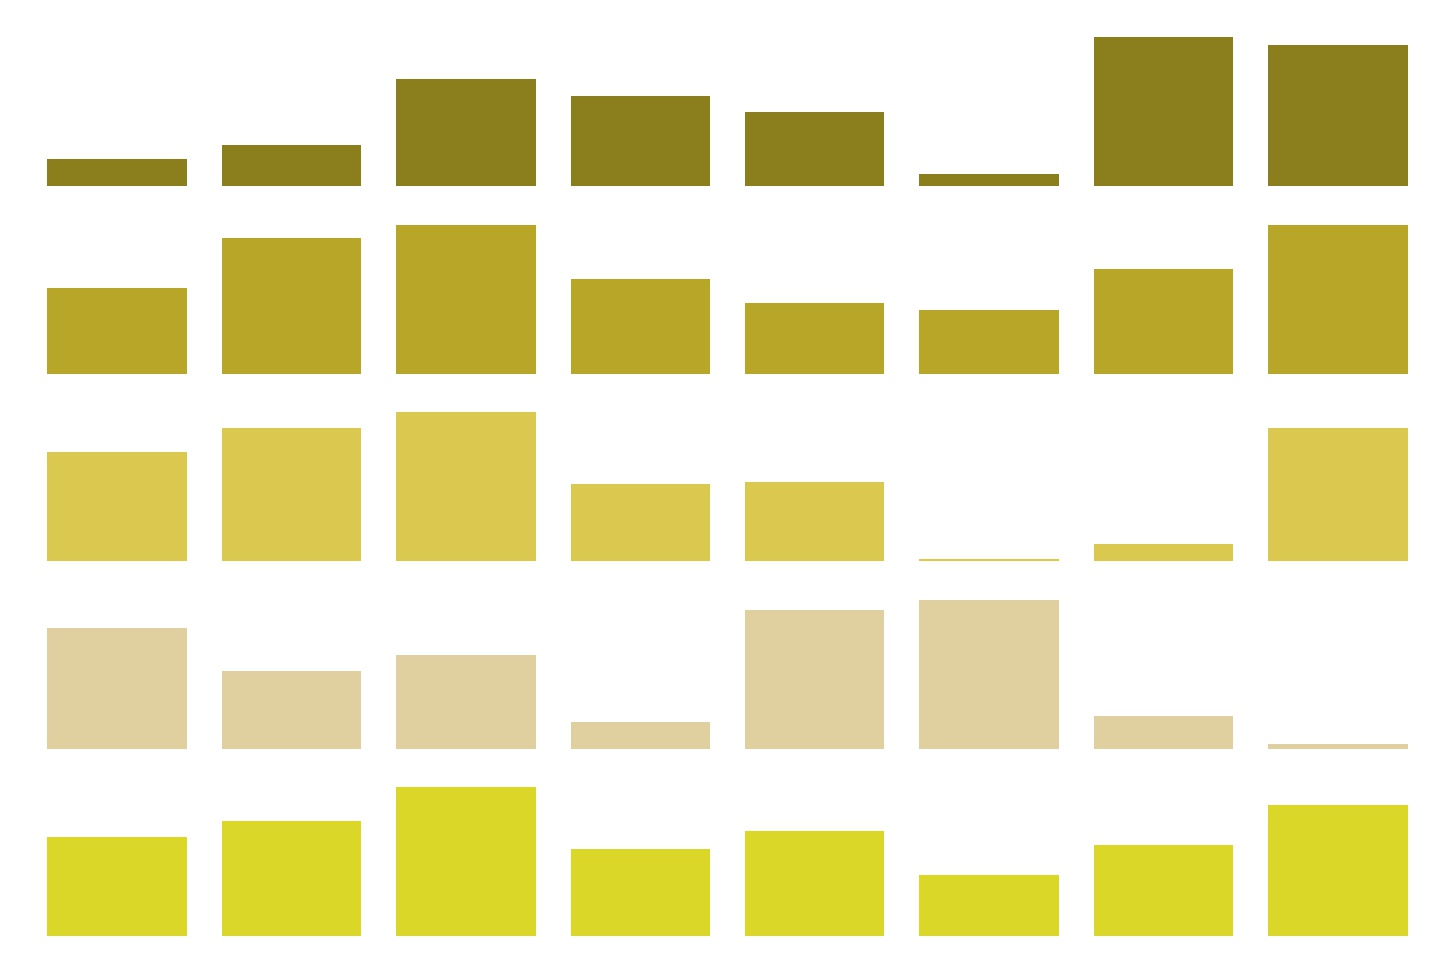

In [183]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(
    nrows = 5,
    ncols = 1
)
colors = ['#9D8C0B', '#CFB80F', '#F1DB37', '#ECD594', '#F9F30B']

for ax, data, c in zip((ax1, ax2, ax3, ax4, ax5), (d1, d2, d3, d4, d5), colors):
    sns.barplot(
        x = 1,
        y = 0,
        data = data,
        color = c,
        ax = ax
    )
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(bottom=False, left=False)
    for i in ['bottom', 'right', 'left', 'top']:
        ax.spines[i].set_visible(None)

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [14]:
fake_expr_val = np.random.random((4, 9))

In [17]:
import matplotlib.pyplot as plt  
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300

In [52]:
help(cbar.set_ticklabels)

Help on method set_ticklabels in module matplotlib.colorbar:

set_ticklabels(ticklabels, update_ticks=True) method of matplotlib.colorbar.Colorbar instance
    Set tick labels.
    
    Tick labels are updated immediately unless *update_ticks* is *False*,
    in which case one should call `.update_ticks` explicitly.



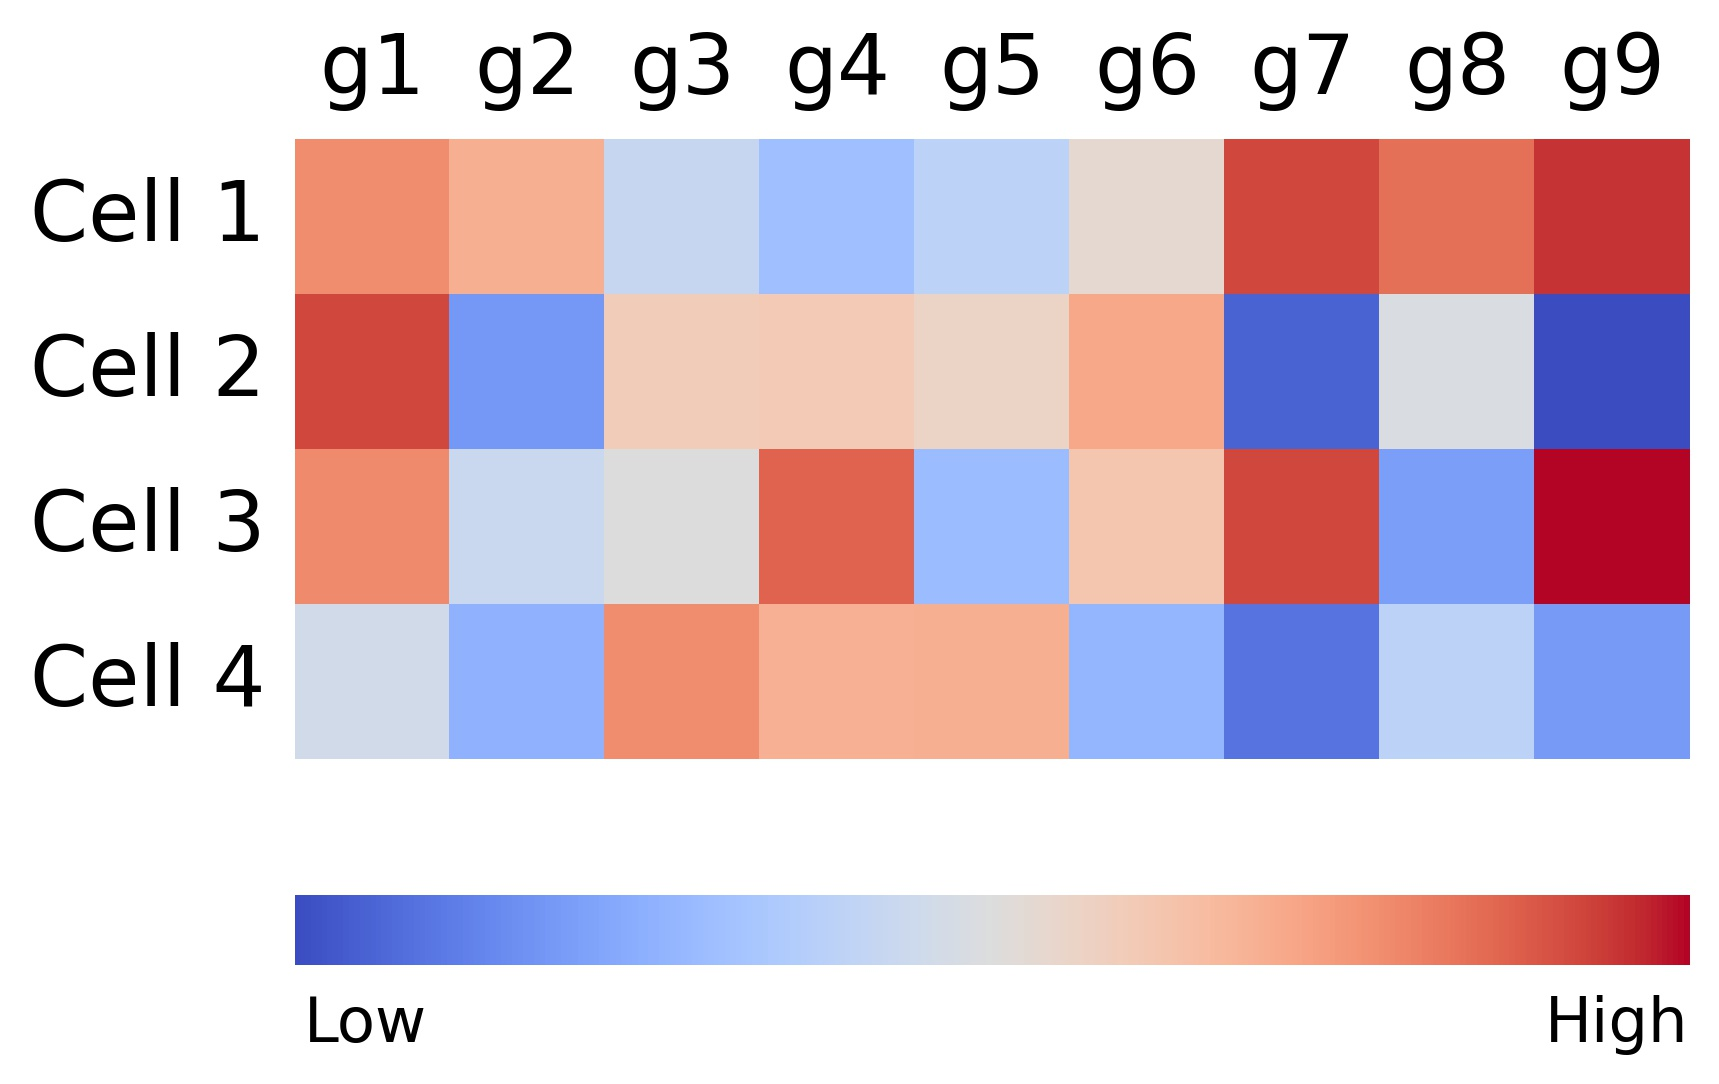

In [58]:
fig, ax = plt.subplots()

sns.heatmap(fake_expr_val, square=True, cmap='coolwarm', cbar_kws={"orientation": "horizontal"})

ax.set_yticklabels([f'Cell {i+1}' for i in range(4)], rotation=0, size=20)
ax.set_xticklabels([f'g{i+1}' for i in range(9)], size=20)
ax.xaxis.set_ticks_position('top')
ax.tick_params(top=False, left=False)
# ax.legend(bbox_to_anchor)

cbar = ax.collections[0].colorbar
cbar.set_ticks([.05, .9])
cbar.set_ticklabels(['Low', 'High'])
cbar.ax.tick_params(bottom=False, labelsize=15)